In [1]:
from denoiser.dsp import convert_audio
from app.denoiser import pretrained

from scipy.signal import spectrogram

import torchaudio
import torch

import matplotlib.pyplot as plt
import numpy as np

device = torch.device('mps')
model = pretrained.dns64().to(device)
wav, sr = torchaudio.load('./data/SeekAndDenoise.wav')

In [2]:
print(f"Running model...")
wav = convert_audio(wav, sr, model.sample_rate, model.chin).to(device)
with torch.no_grad():
    denoised = model(wav[None])[0]

print(f"Playing audio...")
denoised = denoised.cpu()
torchaudio.save('./data/denoised.wav', denoised, model.sample_rate)

Running model...
Playing audio...


Plotting spectrograms...


/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7773: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


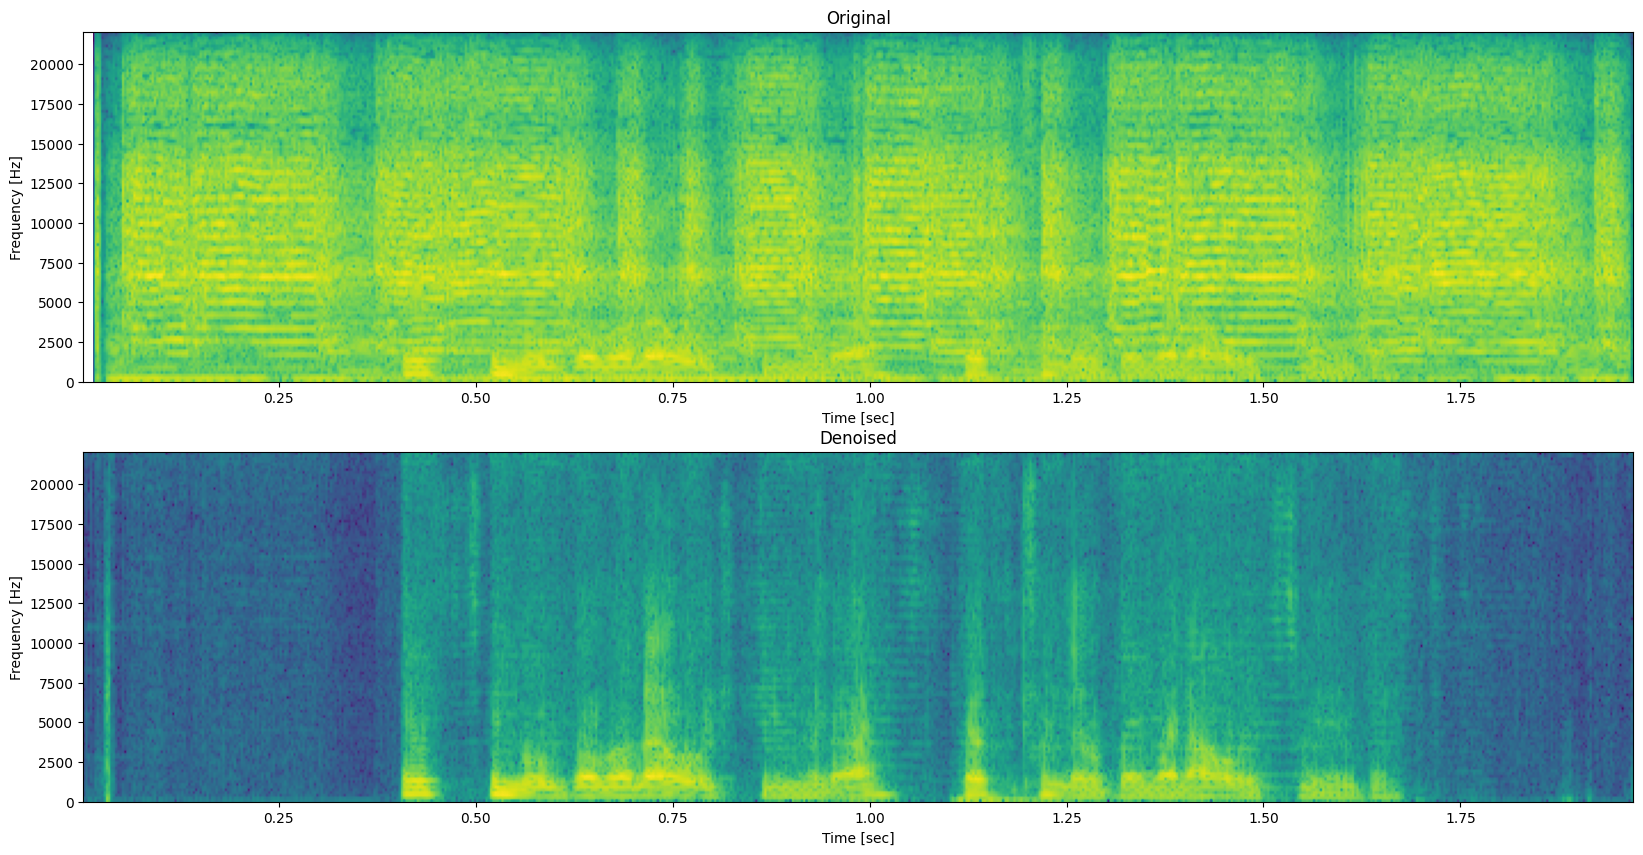

In [18]:
denoised_signal = denoised.cpu().numpy().squeeze()
wav_signal = wav.cpu().numpy().squeeze()

print(f"Plotting spectrograms...")
_, _, spec = spectrogram(wav_signal, sr)
_, _, spec_denoised = spectrogram(denoised_signal, sr)

plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
plt.title("Original")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [sec]")
plt.specgram(wav_signal, Fs=sr)

plt.subplot(2, 1, 2)
plt.title("Denoised")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [sec]")
plt.specgram(denoised_signal, Fs=sr)

plt.show()